## CS 445: Computational Photography

## Programming Project #3: Gradient Domain Fusion

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from random import random
import time
import scipy
import scipy.sparse.linalg

# modify to where you store your project data including utils.py
datadir = "/content/drive/My Drive/Fall 2022/CS 445/Project 3/"

utilfn = datadir + "utils.py"
!cp "$utilfn" .
samplesfn = datadir + "samples"
!cp -r "$samplesfn" .
Photosfn = datadir + "Photos"
!cp -r "$Photosfn" .
import utils
from utils import *

## Part 1 Toy Problem (20 pts)

In [ ]:
def toy_reconstruct(img):
    """
    The implementation for gradient domain processing is not complicated, but it is easy to make a mistake, so let's start with a toy example. Reconstruct this image from its gradient values, plus one pixel intensity. Denote the intensity of the source image at (x, y) as s(x,y) and the value to solve for as v(x,y). For each pixel, then, we have two objectives:
    1. minimize (v(x+1,y)-v(x,y) - (s(x+1,y)-s(x,y)))^2
    2. minimize (v(x,y+1)-v(x,y) - (s(x,y+1)-s(x,y)))^2
    Note that these could be solved while adding any constant value to v, so we will add one more objective:
    3. minimize (v(1,1)-s(1,1))^2
    
    :param toy_img: numpy.ndarray
    """
    
    # TO DO

    im_h, im_w = img.shape
    im2var = np.arange(im_h * im_w).reshape(im_h, im_w)
    # print(im_h, im_w)

    nr = im_h
    nc = im_w
    neq = (im_h)*(im_w-1) + (im_w)*(im_h-1) + 1 # number of equations
    A = scipy.sparse.lil_matrix((neq, nr*nc), dtype='double') # init lil
    # print("A shape:", A.shape)
    b = np.zeros((neq,1), dtype='double')
    # print("b shape:", b.shape)

    ### [ code to fill values here ]

    e = 0
    for x in range (im_w-1):
      for y in range (im_h):
        # print(x,y, "e:", e)
        A[e, im2var[y][x+1]] = 1
        A[e, im2var[y][x]] = -1
        b[e] = img[y][x+1] - img[y][x]
        e = e + 1;
    
    # print("Finished polulating x gradients")

    for x in range (im_w):
      for y in range (im_h-1):
        A[e, im2var[y+1][x]] = 1
        A[e, im2var[y][x]] = -1
        b[e] = img[y+1][x] - img[y][x]
        e = e + 1;

    # print("Finished polulating y gradients")

    A[e, im2var[0][0]] = 1
    b[e] = img[0][0] 

    # print("Finished polulating (0,0) gradients")

    v = scipy.sparse.linalg.lsqr(A.tocsr(), b); # solve w/ csr
    print(v)
    out_img = v[0].reshape(im_h, im_w)

    return out_img

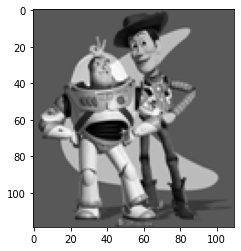

(array([0.34509988, 0.34510081, 0.34510143, ..., 0.34509311, 0.34509299,
       0.34509295]), 1, 594, 2.6165903651599334e-05, 2.6165903651599334e-05, 48.72776147069914, 11585.258295024978, 1.160133681497526e-05, 53.99466317916018, array([0., 0., 0., ..., 0., 0., 0.]))


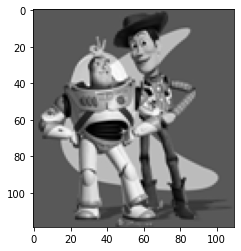

Max error is:  8.07367729466213e-06


In [ ]:
toy_img = cv2.cvtColor(cv2.imread('samples/toy_problem.png'), cv2.COLOR_BGR2GRAY).astype('double') / 255.0
plt.imshow(toy_img, cmap="gray")
plt.show()

im_out = toy_reconstruct(toy_img)
plt.imshow(im_out, cmap="gray")
plt.show()
print("Max error is: ", np.sqrt(((im_out - toy_img)**2).max()))

## Preparation

In [ ]:
background_img = cv2.cvtColor(cv2.imread('samples/im2.JPG'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.figure()
plt.imshow(background_img)
plt.show()
object_img = cv2.cvtColor(cv2.imread('samples/penguin-chick.jpeg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.imshow(object_img)
plt.show()

use_interface = False  # set to true if you want to use the interface to choose points (might not work in Colab)
if not use_interface:
  xs = (65, 359, 359, 65)
  ys = (24, 24, 457, 457)
  object_mask = utils.get_mask(ys, xs, object_img)
  bottom_center = (500, 2500) # (x,y)

  # Need to adjust mask so it isnt tight along image boundary
  # object_img, object_mask = utils.crop_object_img(object_img, object_mask)
  bg_ul = utils.upper_left_background_rc(object_mask, bottom_center)
  print(bg_ul)
  plt.imshow(utils.get_combined_img(background_img, object_img, object_mask, bg_ul))

  plt.imshow(object_mask, cmap='gray')

In [ ]:
if use_interface:
  import matplotlib.pyplot as plt
  %matplotlib notebook
  mask_coords = specify_mask(object_img)

In [ ]:
if use_interface:
  xs = mask_coords[0]
  ys = mask_coords[1]
  %matplotlib inline
  import matplotlib.pyplot as plt
  plt.figure()
  object_mask = get_mask(ys, xs, object_img)

In [ ]:
if use_interface:
  %matplotlib notebook
  import matplotlib.pyplot as plt
  bottom_center = specify_bottom_center(background_img)
  %matplotlib inline
  import matplotlib.pyplot as plt

  object_img, object_mask = utils.crop_object_img(object_img, object_mask)
  bg_ul = utils.upper_left_background_rc(object_mask, bottom_center)
  plt.imshow(utils.get_combined_img(background_img, object_img, object_mask, bg_ul))



## Part 2 Poisson Blending (50 pts)

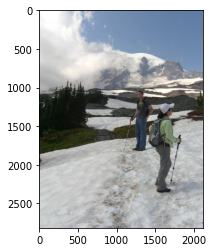

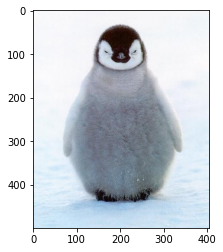

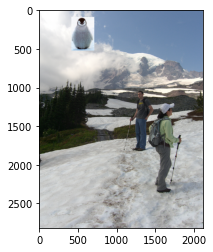

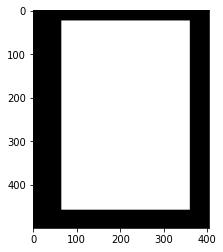

In [ ]:
# Sample Images

background_img = cv2.cvtColor(cv2.imread('samples/im2.JPG'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.figure()
plt.imshow(background_img)
plt.show()
object_img = cv2.cvtColor(cv2.imread('samples/penguin-chick.jpeg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.imshow(object_img)
plt.show()

use_interface = False  # set to true if you want to use the interface to choose points (might not work in Colab)
if not use_interface:
  xs = (65, 359, 359, 65)
  ys = (24, 24, 457, 457)
  object_mask = utils.get_mask(ys, xs, object_img)
  bottom_center = (500, 500) # (x,y)

  object_img2, object_mask2 = utils.crop_object_img(object_img, object_mask)
  bg_ul = utils.upper_left_background_rc(object_mask2, bottom_center)
  # print(bg_ul)
  plt.imshow(utils.get_combined_img(background_img, object_img, object_mask, bg_ul))
  plt.show()
  
  plt.imshow(object_mask, cmap='gray')


### My Prep

In [ ]:
# My Images, result 1

background_img = cv2.cvtColor(cv2.imread('Photos/lake2.jpg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
object_img = cv2.cvtColor(cv2.imread('Photos/seals.jpg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 

scale_bg = 50
width = int(background_img.shape[1] * scale_bg / 100)
height = int(background_img.shape[0] * scale_bg / 100)
dim = (width, height)
background_img = cv2.resize(background_img, dim)

scale_obj = 50
width = int(object_img.shape[1] * scale_obj / 100)
height = int(object_img.shape[0] * scale_obj / 100)
dim = (width, height)
object_img = cv2.resize(object_img, dim)

plt.figure()
plt.imshow(background_img)
plt.show()
plt.imshow(object_img)
plt.show()

use_interface = False  # set to true if you want to use the interface to choose points (might not work in Colab)
if not use_interface:
  xs = np.array([180,800])*scale_obj/100
  ys = np.array([150, 650])*scale_obj/100
  xs = (xs[0], xs[1], xs[1], xs[0])
  ys = (ys[0], ys[0], ys[1], ys[1])
  object_mask = utils.get_mask(ys, xs, object_img)
  bottom_center = (180, 280) # (x,y)

  object_img2, object_mask2 = utils.crop_object_img(object_img, object_mask)
  bg_ul = utils.upper_left_background_rc(object_mask2, bottom_center)
  print(bg_ul)
  plt.imshow(utils.get_combined_img(background_img, object_img, object_mask, bg_ul))
  plt.show()

  plt.imshow(object_mask, cmap='gray')

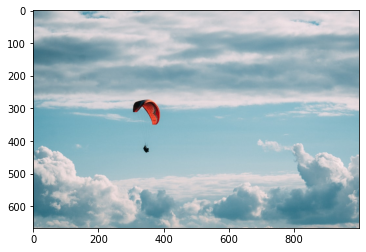

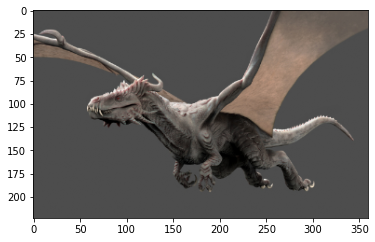

[294, 426]


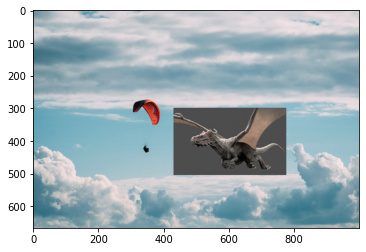

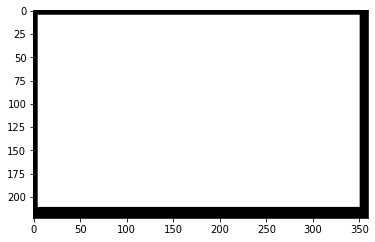

In [ ]:
# My Images, result 2

background_img = cv2.cvtColor(cv2.imread('Photos/sky.jpg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.figure()
plt.imshow(background_img)
plt.show()
object_img = cv2.cvtColor(cv2.imread('Photos/dragon.jpg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 

scale_percent = 60
width = int(object_img.shape[1] * scale_percent / 100)
height = int(object_img.shape[0] * scale_percent / 100)
dim = (width, height)
object_img = cv2.resize(object_img, dim)

plt.imshow(object_img)
plt.show()

use_interface = False  # set to true if you want to use the interface to choose points (might not work in Colab)
if not use_interface:
  xs = (5,350)
  ys = (5, 210)
  xs = (xs[0], xs[1], xs[1], xs[0])
  ys = (ys[0], ys[0], ys[1], ys[1])
  object_mask = utils.get_mask(ys, xs, object_img)
  bottom_center = (600, 500) # (x,y)

  object_img2, object_mask2 = utils.crop_object_img(object_img, object_mask)
  bg_ul = utils.upper_left_background_rc(object_mask2, bottom_center)
  print(bg_ul)
  plt.imshow(utils.get_combined_img(background_img, object_img, object_mask, bg_ul))
  plt.show()

  plt.imshow(object_mask, cmap='gray')

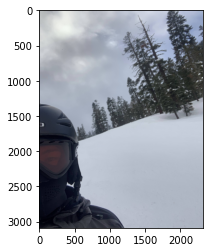

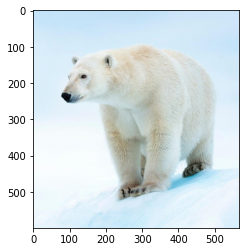

[889, 549]


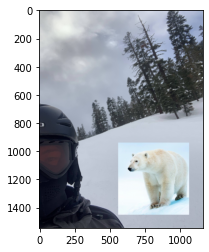

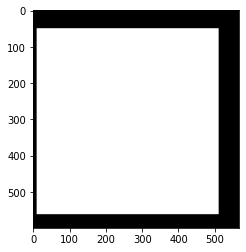

In [ ]:
# My Images, result 3

background_img = cv2.cvtColor(cv2.imread('Photos/snow.jpg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.figure()
plt.imshow(background_img)
plt.show()
object_img = cv2.cvtColor(cv2.imread('Photos/polarbear.jpg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 

scale_percent = 50
width = int(background_img.shape[1] * scale_percent / 100)
height = int(background_img.shape[0] * scale_percent / 100)
dim = (width, height)
background_img = cv2.resize(background_img, dim)

# scale_percent = 95
# width = int(object_img.shape[1] * scale_percent / 100)
# height = int(object_img.shape[0] * scale_percent / 100)
# dim = (width, height)
# object_img = cv2.resize(object_img, dim)

plt.imshow(object_img)
plt.show()

use_interface = False  # set to true if you want to use the interface to choose points (might not work in Colab)
if not use_interface:
  xs = (10,510)
  ys = (50, 560)
  xs = (xs[0], xs[1], xs[1], xs[0])
  ys = (ys[0], ys[0], ys[1], ys[1])
  object_mask = utils.get_mask(ys, xs, object_img)
  bottom_center = (800, 1400) # (x,y)

  object_img2, object_mask2 = utils.crop_object_img(object_img, object_mask)
  bg_ul = utils.upper_left_background_rc(object_mask2, bottom_center)
  print(bg_ul)
  plt.imshow(utils.get_combined_img(background_img, object_img, object_mask, bg_ul))
  plt.show()

  plt.imshow(object_mask, cmap='gray')

### Run Blends

In [ ]:
def poisson_blend(object_img, object_mask, bg_img, bg_ul):
    """
    Returns a Poisson blended image with masked object_img over the bg_img at position specified by bg_ul.
    Can be implemented to operate on a single channel or multiple channels
    :param object_img: the image containing the foreground object
    :param object_mask: the mask of the foreground object in object_img
    :param background_img: the background image 
    :param bg_ul: position (row, col) in background image corresponding to (0,0) of object_img 
    """
    #TO DO 

    def get_neighbors(i, j):
        return [(i,j+1),(i,j-1),(i+1,j),(i-1,j)]

    # nnz = (object_mask>0).sum() # number of non-zero values in object_mask
    # im2var = -np.ones(object_img.shape[0:2], dtype='int32') # values are -1 outside mask
    # im2var[object_mask>0] = np.arange(nnz) # numberd values are given inside mask
    
    img_h, img_w = object_img.shape
    im2var = np.arange(img_h * img_w).reshape(img_h, img_w) #im2var has same shape as object_img
    # print(im2var)

    # number of equations will be determined by looping through object mask and 
    # counting number of pairs of neighboring pixels is at least one pixel in the mask

    # If pixel is in first/last row/column, its a boundary pixel. We need gradient between target and background to match source gradients
    # Otherwise, its not a boundary pixel and we need gradients within target to match source gradients
    # Plan:
    # Create list of x coordinates and y coordinates within the mask
    # Loop through each pixel in the mask. For each pixel, look at all its neighbors.
    # If that neighbor is in the mask, we set A and b to match gradients from source
    # If that neighbor is not in the mask, we set A and b to match target/background gradient to source

    # Create arrays of x and y coordinates within mask (i_coord, j_coord)
    [i_c, j_c] = np.nonzero(object_mask) # gives us two 1 x n arrays, x and y coordinate lists

    neq = 4*len(i_c)+1
    A = scipy.sparse.lil_matrix((neq, img_h*img_w), dtype='double') # init lil
    b = np.zeros((neq,1), dtype='double')
    bg_patch = bg_img[bg_ul[0]:bg_ul[0] + img_h, bg_ul[1]:bg_ul[1] + img_w]
    
    print(object_img.shape)
    print(bg_patch.shape)
    print(object_mask.shape)
    # plt.figure(figsize=(5,5))
    # plt.imshow(object_img) # object
    # plt.figure(figsize=(5,5))
    # plt.imshow(bg_patch) # background patch
    # plt.figure(figsize=(5,5))
    # plt.imshow(object_mask, cmap ='gray') # mask
    # plt.show()

    e = 0
    for p in range (len(i_c)):
      [i,j] = [i_c[p],j_c[p]] # the mask coordinates we are looking at 
      for (i_n,j_n) in get_neighbors(i,j): # neighbor coords
        if object_mask[i_n,j_n]: # Neighbor in mask, match target to source gradient
          A[e, im2var[i,j]] = 1
          A[e, im2var[i_n,j_n]] = -1
          b[e] = object_img[i,j] - object_img[i_n,j_n]
        else: 
          A[e, im2var[i,j]] = 1
          b[e] = object_img[i,j] - object_img[i_n,j_n] + bg_patch[i_n,j_n] # need to shift bg image
        e = e + 1;

    v = scipy.sparse.linalg.lsqr(A.tocsr(), b); # solve w/ csr
    out_img = -bg_patch
    for p in range(len(i_c)):
         [i,j] = [i_c[p],j_c[p]]
         out_img[i,j] = v[0][im2var[i,j]]

    return out_img

(223, 360)
(223, 360)
(223, 360)
(223, 360)
(223, 360)
(223, 360)
(223, 360)
(223, 360)
(223, 360)


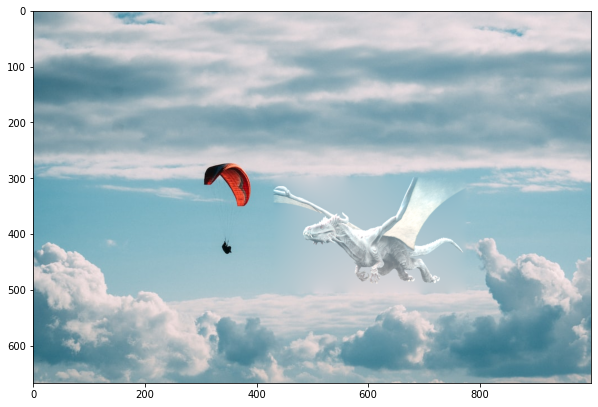

In [ ]:
# Run blend using prepared image files
out_img = np.zeros(object_img.shape)

for b in np.arange(3):
  out_img[:,:,b] = poisson_blend(object_img[:,:,b], object_mask, background_img[:,:,b].copy(), bg_ul)

im_blend = utils.get_combined_img(background_img, out_img, object_mask, bg_ul)

plt.figure(figsize=(10,10))
plt.imshow(im_blend)

## Part 3 Mixed Gradients (20 pts)

### Prep

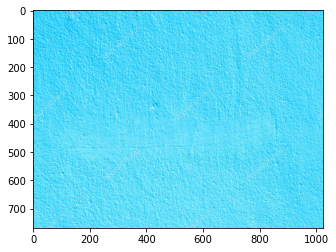

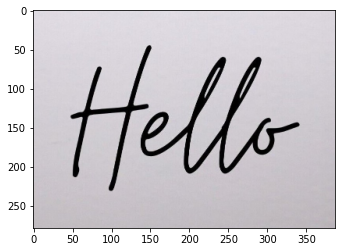

[124, 329]


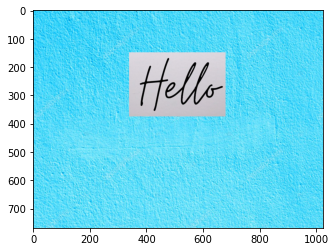

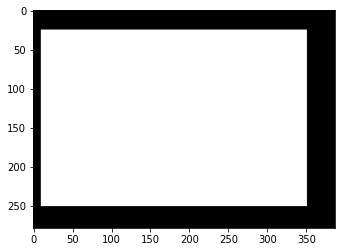

In [ ]:
# My Images, result 1

background_img = cv2.cvtColor(cv2.imread('Photos/wall2.jpg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
object_img = cv2.cvtColor(cv2.imread('Photos/writing.jpg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 

scale_percent = 100
# width = int(background_img.shape[1] * scale_percent / 100)
# height = int(background_img.shape[0] * scale_percent / 100)
# dim = (width, height)
# background_img = cv2.resize(background_img, dim)

scale_percent = 50
width = int(object_img.shape[1] * scale_percent / 100)
height = int(object_img.shape[0] * scale_percent / 100)
dim = (width, height)
object_img = cv2.resize(object_img, dim)

plt.figure()
plt.imshow(background_img)
plt.show()
plt.imshow(object_img)
plt.show()

use_interface = False  # set to true if you want to use the interface to choose points (might not work in Colab)
if not use_interface:
  xs = np.array([20,700])*scale_percent/100
  ys = np.array([50, 500])*scale_percent/100
  xs = (xs[0], xs[1], xs[1], xs[0])
  ys = (ys[0], ys[0], ys[1], ys[1])
  object_mask = utils.get_mask(ys, xs, object_img)
  bottom_center = (500, 350) # (x,y)

  object_img2, object_mask2 = utils.crop_object_img(object_img, object_mask)
  bg_ul = utils.upper_left_background_rc(object_mask2, bottom_center)
  print(bg_ul)
  plt.imshow(utils.get_combined_img(background_img, object_img, object_mask, bg_ul))
  plt.show()

  plt.imshow(object_mask, cmap='gray')

In [ ]:
# My Images, result 2

background_img = cv2.cvtColor(cv2.imread('Photos/wall3.jpg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
object_img = cv2.cvtColor(cv2.imread('Photos/tyler.jpg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 

scale_percent = 100
# width = int(background_img.shape[1] * scale_percent / 100)
# height = int(background_img.shape[0] * scale_percent / 100)
# dim = (width, height)
# background_img = cv2.resize(background_img, dim)

scale_percent = 7
width = int(object_img.shape[1] * scale_percent / 100)
height = int(object_img.shape[0] * scale_percent / 100)
dim = (width, height)
object_img = cv2.resize(object_img, dim)

plt.figure()
plt.imshow(background_img)
plt.show()
plt.imshow(object_img)
plt.show()

use_interface = False  # set to true if you want to use the interface to choose points (might not work in Colab)
if not use_interface:
  xs = np.array([5,200])
  ys = np.array([20, 260])
  xs = (xs[0], xs[1], xs[1], xs[0])
  ys = (ys[0], ys[0], ys[1], ys[1])
  object_mask = utils.get_mask(ys, xs, object_img)
  bottom_center = (225, 290) # (x,y)

  object_img2, object_mask2 = utils.crop_object_img(object_img, object_mask)
  bg_ul = utils.upper_left_background_rc(object_mask2, bottom_center)
  print(bg_ul)
  plt.imshow(utils.get_combined_img(background_img, object_img, object_mask, bg_ul))
  plt.show()

  plt.imshow(object_mask, cmap='gray')

### Run Blends

In [ ]:
def mixed_blend(object_img, object_mask, bg_img, bg_ul):
    """
    Returns a mixed gradient blended image with masked object_img over the bg_img at position specified by bg_ul.
    Can be implemented to operate on a single channel or multiple channels
    :param object_img: the image containing the foreground object
    :param object_mask: the mask of the foreground object in object_img
    :param background_img: the background image 
    :param bg_ul: position (row, col) in background image corresponding to (0,0) of object_img 
    """
    #TO DO 

    def get_neighbors(i, j):
        return [(i,j+1),(i,j-1),(i+1,j),(i-1,j)]

    img_h, img_w = object_img.shape
    im2var = np.arange(img_h * img_w).reshape(img_h, img_w) #im2var has same shape as object_img

    # Create arrays of x and y coordinates within mask (i_coord, j_coord)
    [i_c, j_c] = np.nonzero(object_mask) # gives us two 1 x n arrays, x and y coordinates within mask

    neq = 4*len(i_c)+1
    A = scipy.sparse.lil_matrix((neq, img_h*img_w), dtype='double') # init lil
    b = np.zeros((neq,1), dtype='double')
    bg_patch = bg_img[bg_ul[0]:bg_ul[0] + img_h, bg_ul[1]:bg_ul[1] + img_w]
    
    print(object_img.shape)

    e = 0
    for p in range (len(i_c)):
      [i,j] = [i_c[p],j_c[p]] # the mask coordinates we are looking at 
      for (i_n,j_n) in get_neighbors(i,j): # neighbor coords
        # print("Source Gradient:", object_img[i,j] - object_img[i_n,j_n])
        # print("Background Gradient:", bg_patch[i,j] - bg_patch[i_n,j_n])
        # print("Source Greater:", abs(object_img[i,j] - object_img[i_n,j_n]) > abs(bg_patch[i,j] - bg_patch[i_n,j_n]))
        sg = object_img[i,j] - object_img[i_n,j_n]
        bg = bg_patch[i,j] - bg_patch[i_n,j_n]
        if abs(sg) > abs(bg):
          gradient = sg
        else:
          gradient = bg
        if object_mask[i_n,j_n]: # Neighbor in mask, match target to source gradient
          A[e, im2var[i,j]] = 1
          A[e, im2var[i_n,j_n]] = -1
          b[e] = gradient
        else: 
          A[e, im2var[i,j]] = 1
          b[e] = gradient + bg_patch[i_n,j_n] # need to shift bg image
        e = e + 1;

    v = scipy.sparse.linalg.lsqr(A.tocsr(), b); # solve w/ csr
    out_img = -bg_patch
    for p in range(len(i_c)):
         [i,j] = [i_c[p],j_c[p]]
         out_img[i,j] = v[0][im2var[i,j]]

    return out_img

(279, 387)
(279, 387)
(279, 387)


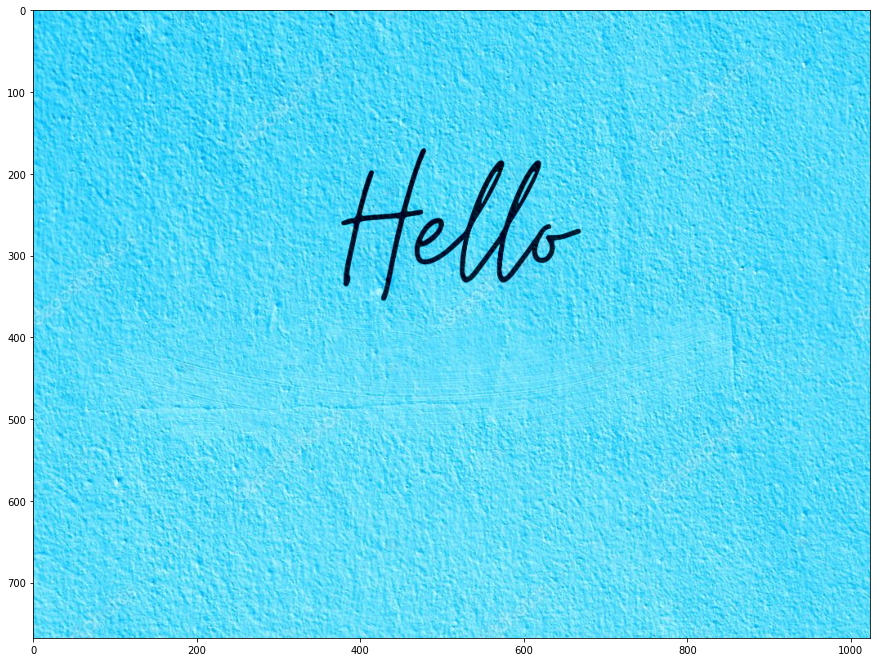

In [ ]:
out_img = np.zeros(object_img.shape)
for b in np.arange(3):
  out_img[:,:,b] = mixed_blend(object_img[:,:,b], object_mask, background_img[:,:,b].copy(), bg_ul)

im_mix = utils.get_combined_img(background_img, out_img, object_mask, bg_ul)

plt.figure(figsize=(15,15))
plt.imshow(im_mix)

# Bells & Whistles (Extra Points)

## Color2Gray (20 pts)

In [ ]:
def color2gray(img):
    # TO DO

    im_h, im_w, chnls = img.shape
    im2var = np.arange(im_h * im_w).reshape(im_h, im_w)

    neq = (im_h)*(im_w-1) + (im_w)*(im_h-1) + 1 # number of equations
    A = scipy.sparse.lil_matrix((neq, im_h*im_w), dtype='double') # init lil
    b = np.zeros((neq,1), dtype='double')

    e = 0
    for x in range (im_w-1):
      for y in range (im_h):
        grad_mags = np.array([abs(img[y,x+1,0] - img[y,x,0]), \
        abs(img[y,x+1,1] - img[y,x,1]),
        abs(img[y,x+1,2] - img[y,x,2])])
        c = np.argmax(grad_mags) #channel with the highest gradient

        A[e, im2var[y,x+1]] = 1
        A[e, im2var[y,x]] = -1
        b[e] = img[y,x+1,c] - img[y,x,c]
        e = e + 1;

    for x in range (im_w):
      for y in range (im_h-1):
        grad_mags = np.array([abs(img[y+1,x,0] - img[y,x,0]), \
        abs(img[y+1,x,1] - img[y,x,1]),
        abs(img[y+1,x,2] - img[y,x,2])])
        c = np.argmax(grad_mags) #channel with the highest gradient

        A[e, im2var[y+1,x]] = 1
        A[e, im2var[y,x]] = -1
        b[e] = img[y+1,x,c] - img[y,x,c]
        e = e + 1;

    A[e, im2var[0][0]] = 1
    b[e] = np.average([img[0,0,0],img[0,0,0],img[0,0,0]])

    # print("Finished polulating (0,0) gradients")

    v = scipy.sparse.linalg.lsqr(A.tocsr(), b)[0]; # solve w/ csr
    out_img = v.reshape(im_h, im_w)

    return out_img

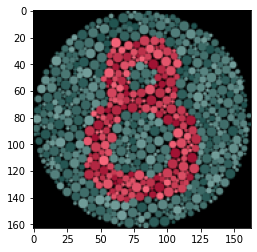

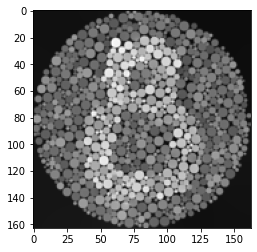

In [ ]:
color_img = cv2.cvtColor(cv2.imread('samples/colorBlind8.png'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 # scale to be from 0 to 1
plt.imshow(color_img, cmap="gray")
plt.show()

im_out = color2gray(color_img)
plt.imshow(im_out, cmap="gray")
plt.show()

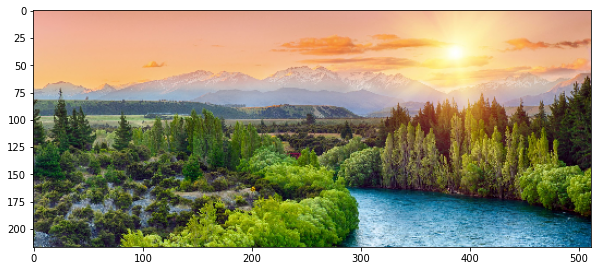

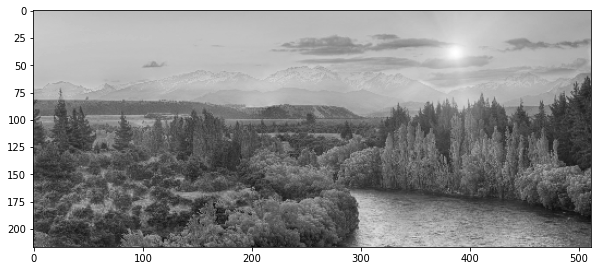

In [ ]:
# Natrual Image
color_img = cv2.cvtColor(cv2.imread('Photos/nature.jpg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 # scale to be from 0 to 1

scale_percent = 20
width = int(color_img.shape[1] * scale_percent / 100)
height = int(color_img.shape[0] * scale_percent / 100)
dim = (width, height)
color_img = cv2.resize(color_img, dim)

plt.figure(figsize=(10,10))
plt.imshow(color_img, cmap="gray")
plt.show()

im_out = color2gray(color_img)
plt.figure(figsize=(10,10))
plt.imshow(im_out, cmap="gray")
plt.show()

## Laplacian pyramid blending (20 pts)

In [ ]:
def laplacian_blend(object_img, object_mask, bg_img, bg_ul):
  # feel free to change input parameters
    pass

## More gradient domain processing (up to 20 pts)